In [15]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from IPython import display

import os
import time
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader


np.random.seed(11)

num_neuro_1 = 10
num_neuro_2 = 10
num_neuro_3 = 5

RES_DIR = './results/'
DATA_DIR = './CCPP/'
HOME_DIR = './'
use_gpu = False

flag=True
l_max, a_max, b_max, l_mean, a_mean, b_mean, l_min, a_min, b_min = 0,0,0, 0,0,0, 0,0,0

In [3]:
def save_wts(net, save_dir, before=False, is_pytorch=False):
    if is_pytorch:
        net_wts = copy.deepcopy(net.state_dict())
        if before:
            torch.save(net_wts, save_dir+'params_before')
        else:
            torch.save(net_wts, save_dir+'params')
    else:
        w1 = pd.DataFrame((net.lin1.W).data.numpy())
        b1 = pd.DataFrame((net.lin1.b).data.numpy())
        w2 = pd.DataFrame((net.lin2.W).data.numpy())
        b2 = pd.DataFrame((net.lin2.b).data.numpy())
        w3 = pd.DataFrame((net.lin3.W).data.numpy())
        b3 = pd.DataFrame((net.lin3.b).data.numpy())
        w4 = pd.DataFrame((net.lin4.W).data.numpy())
        b4 = pd.DataFrame((net.lin4.b).data.numpy())
        if before:
            w1.to_csv(save_dir+'w1_before.csv', index=False)
            w2.to_csv(save_dir+'w2_before.csv', index=False)
            w3.to_csv(save_dir+'w3_before.csv', index=False)
            w4.to_csv(save_dir+'w4_before.csv', index=False)
            b1.to_csv(save_dir+'b1_before.csv', index=False)
            b2.to_csv(save_dir+'b2_before.csv', index=False)
            b3.to_csv(save_dir+'b3_before.csv', index=False)
            b4.to_csv(save_dir+'b4_before.csv', index=False)
        else:
            w1.to_csv(save_dir+'w1_.csv', index=False)
            w2.to_csv(save_dir+'w2_.csv', index=False)
            w3.to_csv(save_dir+'w3_.csv', index=False)
            w4.to_csv(save_dir+'w4_.csv', index=False)
            b1.to_csv(save_dir+'b1_.csv', index=False)
            b2.to_csv(save_dir+'b2_.csv', index=False)
            b3.to_csv(save_dir+'b3_.csv', index=False)
            b4.to_csv(save_dir+'b4_.csv', index=False)
            

In [4]:
# data - tensor
def search_crit(data, crit):
    max_value_in_column, max_line_ids, max_value, max_column_id = None, None, None, None
    
    if crit=='max':
        max_value_in_column, max_line_ids = torch.max(data,0)
        max_value , max_column_id = torch.max(max_value_in_column, 0)
    elif crit=='mean':
        max_value_in_column, max_line_ids = torch.median(data,0)
        max_value , max_column_id = torch.median(max_value_in_column, 0)
    else:
        max_value_in_column, max_line_ids = torch.min(data,0)
        max_value , max_column_id = torch.min(max_value_in_column, 0)
    
    return max_line_ids[max_column_id[0]],max_column_id[0], max_value[0]


def search_lr_i(net, opt_state, crit):
    left_board, right_board, layer,value = 0, 0, 0, 0.0

    buf = [[],[],[],[]]
    idx=1
    for m in net.modules():
        if isinstance(m, nn.Linear):
            a, b, m = search_crit(opt_state[m.weight]['step_size'], crit)
            buf[0].append(a)
            buf[1].append(b)
            buf[2].append(m)
            buf[3].append(idx)
            idx += 1
    print(buf)
    if crit=='max':
        left_board = buf[0][np.argmax(buf[2])]
        right_board = buf[1][np.argmax(buf[2])]
        value = buf[2][np.argmax(buf[2])]
        layer = buf[3][np.argmax(buf[2])]
    elif crit=='min':
        left_board = buf[0][np.argmin(buf[2])]
        right_board = buf[1][np.argmin(buf[2])]
        value = buf[2][np.argmin(buf[2])]
        layer = buf[3][np.argmin(buf[2])]
    else:
        left_board = buf[0][np.argwhere(buf[2][i]==np.median(buf[2]) for i in range(len(buf[2])))[0,0]]
        right_board = buf[1][np.argwhere(buf[2][i]==np.median(buf[2]) for i in range(len(buf[2])))[0,0]]
        value = buf[2][np.argwhere(buf[2][i]==np.median(buf[2]) for i in range(len(buf[2])))[0,0]]
        layer = buf[3][np.argwhere(buf[2][i]==np.median(buf[2]) for i in range(len(buf[2])))[0,0]]
        
    return layer, left_board, right_board


def define_module(net, layer):
    if layer==1:
        return net.fc1
    elif layer==2:
        return net.fc2
    elif layer==3:
        return net.fc3
    else:
        return net.fc4

In [5]:
from IPython import display

# обучение модели; dataloader разделен на обуч. и валид. выборки
def train_model(model, name, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25, need_wts=False, need_lr=False):
    since = time.time()
    fig = plt.figure()
    
    err_epoh = []
    valid_err_epoh = []
    test_err_epoh = []
    lr_list = {'max': [], 'mean': [], 'min': []}
    wts_list = []
    for i in range(8):
        wts_list.append([])
        
    m_max, m_mean, m_min = None, None, None

    for epoch in range(num_epochs):
        
        if (epoch%10 == 9):
            plt.grid(True)
            plt.plot(err_epoh, color='r')
            plt.plot(valid_err_epoh, color='b')
            plt.plot(test_err_epoh, color='g')
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print("train: ", err_epoh[epoch-1])
            print("valid: ", valid_err_epoh[epoch-1])
            print("test: ", test_err_epoh[epoch-1])
            print(a_max, b_max, l_max, a_mean, b_mean, l_mean, a_min, b_min, l_min)
            print('-' * 10)          
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0                
            
            # Iterate over data.
            data = datasets[phase].data
                # get the inputs
            inputs, labels = torch.FloatTensor(data[:, 0:IN_SIZE]), torch.FloatTensor(data[:, IN_SIZE]).unsqueeze(1)

                # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda(CUDA_DEVICE))
                labels = Variable(labels.cuda(CUDA_DEVICE))
            else:
                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
            optimizer.zero_grad()

                # forward
            outputs = model(inputs)
            #print(outputs.size())
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

                # statistics
            running_loss += loss.data[0] * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            
            # для графиков E(t)
            if phase == 'train':
                err_epoh.append(epoch_loss)
                
                #max, mean, min скорости по всем параметрам
                if need_lr:
                    lr_list['max'].append(optimizer.state[define_module(model, l_max).weight]['step_size'][a_max,b_max])
                    lr_list['mean'].append(optimizer.state[define_module(model, l_mean).weight]['step_size'][a_mean,b_mean])
                    lr_list['min'].append(optimizer.state[define_module(model, l_min).weight]['step_size'][a_min,b_min])
                # для графиков w(t)
                if need_wts:
                    wts_list[0].append(optimizer.state[model.fc1.weight]['step_size'][0,2])
                    wts_list[1].append(optimizer.state[model.fc1.weight]['step_size'][8,1])
                    wts_list[2].append(optimizer.state[model.fc2.weight]['step_size'][2,3])
                    wts_list[3].append(optimizer.state[model.fc2.weight]['step_size'][8,8])
                    wts_list[4].append(optimizer.state[model.fc3.weight]['step_size'][4,7])
                    wts_list[5].append(optimizer.state[model.fc3.weight]['step_size'][2,0])
                    wts_list[6].append(optimizer.state[model.fc4.weight]['step_size'][0,0])
                    wts_list[7].append(optimizer.state[model.fc4.weight]['step_size'][0,2])
            
            elif phase == 'val':
                valid_err_epoh.append(epoch_loss)
            else:
                test_err_epoh.append(epoch_loss)
                
            
            
            if (epoch%500 == 1):
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    plt.savefig(name)
    return model, wts_list, lr_list, err_epoh, valid_err_epoh, test_err_epoh

In [6]:
learn_data = pd.read_csv(HOME_DIR+'split_data/train_set.csv').values
print(learn_data.shape)

BATCH_SIZE = len(learn_data)
IN_SIZE = learn_data.shape[1]-1

(5622, 5)


In [7]:
class CCPPDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
datasets = {x: CCPPDataset(pd.read_csv(HOME_DIR+'split_data/'+x+'_set.csv').values)
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

In [8]:
class MainPyNet(nn.Module):
    
    def __init__(self, in_size, out_size):
        super(MainPyNet, self).__init__()
        
        self.fc1 = nn.Linear(in_size, num_neuro_1)
        self.fc2 = nn.Linear(num_neuro_1, num_neuro_2)
        self.fc3 = nn.Linear(num_neuro_2, num_neuro_3)
        self.fc4 = nn.Linear(num_neuro_3, out_size)
        
        #for m in self.modules():
          #  m.weight.data.normal_(0, 1)
          #  m.bias.data.fill_(1)
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        return x

In [16]:
# начальная точка длля всех моделей pytorch
net = MainPyNet(IN_SIZE, 1)
print(net)

num_epoch = 60
lr = 1e-3

errs_list = {'train': [], 'val': [], 'test': []}

MainPyNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)


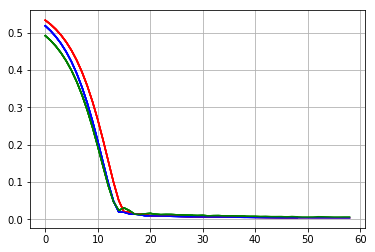

Epoch 59/59
train:  0.0041303979232907295
valid:  0.0040526860393583775
test:  0.006687461398541927
1 1 1 1 1 1 1 1 1
----------
Training complete in 0m 1s
train: 0.004105153493583202
valid: 0.004026827402412891
test: 0.0066363997757434845


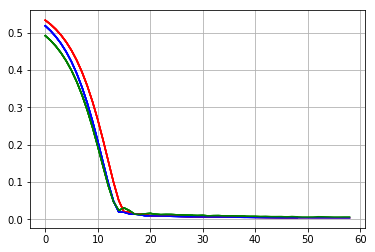

In [17]:
for i in range(1):
    
    if flag:
        flag = False
        l_max, a_max, b_max = 1, 1, 1
        l_mean, a_mean, b_mean = 1, 1, 1
        l_min, a_min, b_min = 1, 1, 1
    else:
        l_max, a_max, b_max = search_lr_i(net, optimizer.state, crit='max')
        print(l_max, a_max, b_max)

        l_mean, a_mean, b_mean = search_lr_i(net, optimizer.state, crit='mean')
        print(l_mean, a_mean, b_mean)

        l_min, a_min, b_min = search_lr_i(net, optimizer.state, crit='min')
        print(l_min, a_min, b_min)
    
    net.load_state_dict(torch.load(HOME_DIR+'split_data/torch_params_before'))

    criterion = nn.MSELoss()
    optimizer = optim.Rprop(net.parameters(), lr=lr)
    sheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    net, wts, lrs, er_list, val_er_list, test_er_list = train_model(net, name=HOME_DIR+'RPROP/errs.png',
                dataloaders=dataloaders, dataset_sizes=dataset_sizes,
                criterion=criterion, optimizer=optimizer, scheduler=sheduler,
                            num_epochs=num_epoch, need_wts=False, need_lr=False)

    errs_list['train'].append(er_list[-1])
    errs_list['val'].append(val_er_list[-1])
    errs_list['test'].append(test_er_list[-1])

    print('train: {}\nvalid: {}\ntest: {}'.format(er_list[-1], val_er_list[-1], test_er_list[-1]))

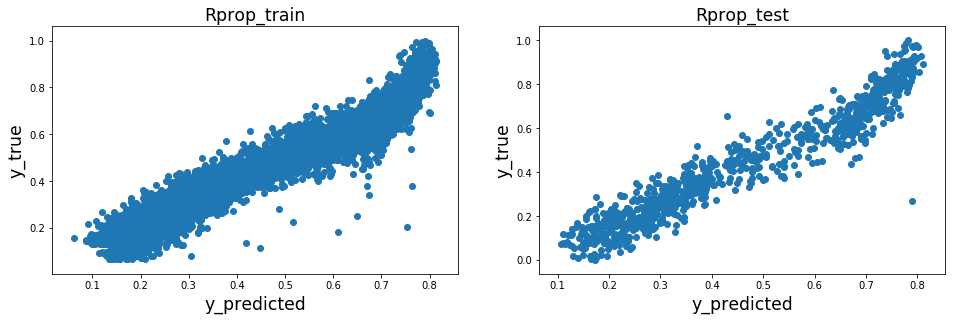

In [19]:
fig = plt.figure(figsize=(16, 10), clear=True)
sub=221
for k in ['train', 'test']:
    plt.subplot(sub)
    sub+=1
    y_pred = net(Variable(torch.FloatTensor(datasets[k].data[:,:IN_SIZE])))

    plt.scatter(y_pred.data.numpy(), datasets[k].data[:,IN_SIZE])
    plt.xlabel('y_predicted', fontsize='xx-large')
    plt.ylabel('y_true', fontsize='xx-large')
    plt.title('Rprop_'+k, fontsize='xx-large')
    #plt.show()
plt.savefig(HOME_DIR+'CHAPTER_5/dispersion_diag.png')

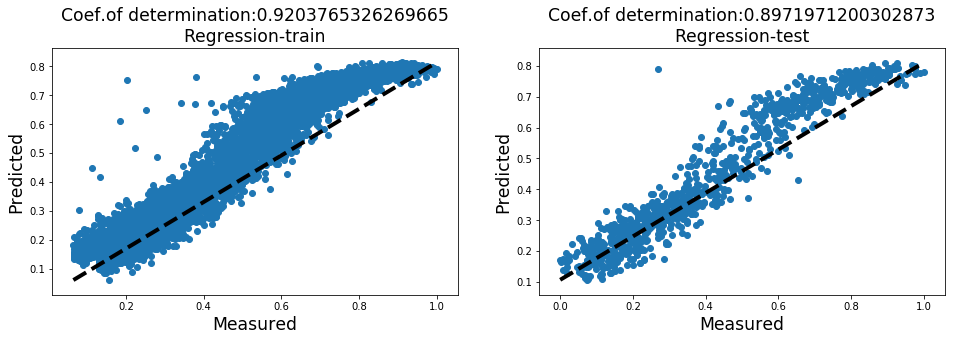

In [32]:
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 10), clear=True)
sub=221
for k in ['train', 'test']:
    #lr = linear_model.LinearRegression()
    y = datasets[k].data[:,IN_SIZE]
    predicted = net(Variable(torch.FloatTensor(datasets[k].data[:,:IN_SIZE])))
    r2 = r2_score(y, predicted.data.numpy())  

    plt.subplot(sub)
    sub+=1
    
    plt.scatter(y, predicted)
    plt.plot([min(y), max(y)], [min(predicted.data.numpy()), max(predicted.data.numpy())], 'k--', lw=4)
    plt.xlabel('Measured', fontsize='xx-large')
    plt.ylabel('Predicted', fontsize='xx-large')
    plt.title('Coef.of determination: '+str(r2)+'\nRegression-'+k, fontsize='xx-large')
plt.savefig(HOME_DIR+'CHAPTER_5/regressions.png')

In [42]:
errs_train = []
errs_test = []

for phase in ['train', 'test']:
    for i in range(len(datasets[phase])):
        pred = net(Variable(torch.FloatTensor(datasets[phase].data[i,:IN_SIZE])))
        
        if phase=='train':
            errs_train.append(datasets[phase].data[i,IN_SIZE]-pred.data[0])
        if phase=='test':
            errs_test.append(datasets[phase].data[i,IN_SIZE]-pred.data[0])

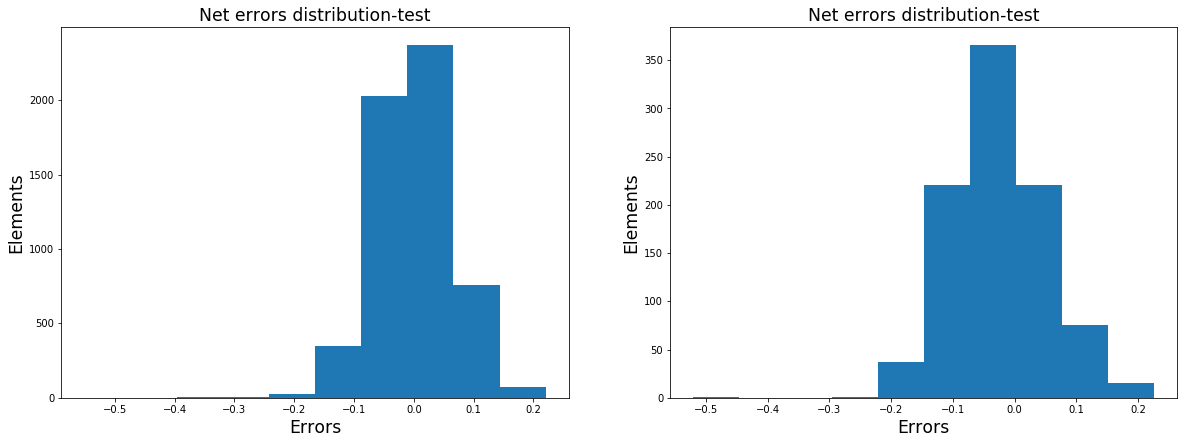

In [44]:
fig = plt.figure(figsize=(20, 15), clear=True)

plt.subplot(221)
plt.hist(errs_train)
plt.xlabel('Errors', fontsize='xx-large')
plt.ylabel('Elements', fontsize='xx-large')
plt.title('Net errors distribution-'+k, fontsize='xx-large')

plt.subplot(222)
plt.hist(errs_test, )
plt.xlabel('Errors', fontsize='xx-large')
plt.ylabel('Elements', fontsize='xx-large')
plt.title('Net errors distribution-'+k, fontsize='xx-large')

plt.savefig(HOME_DIR+'CHAPTER_5/hists.png')

In [62]:
w = net.fc1.weight.data.numpy()
b = net.fc1.bias.data.numpy().reshape((10,1))
a = np.hstack((w, b))
a

array([[-0.42434576,  0.20934871,  0.10357593,  0.18740891, -0.09341835],
       [-0.2813046 ,  0.57178754,  0.07063107, -0.41012946, -0.07447869],
       [-0.34057674, -0.23615162,  0.20412059, -0.3479493 ,  0.11456454],
       [ 0.3472146 , -0.18560722,  0.15131548,  0.44755664, -0.3118925 ],
       [ 0.31629306, -0.37015098, -0.47746316, -0.01220629, -0.1252745 ],
       [-0.17676215,  0.3871225 ,  0.37786582,  0.22950386, -0.06629619],
       [ 0.0711855 , -0.10986173, -0.2337737 ,  0.28714225, -0.16402729],
       [-0.06859224, -0.0142671 , -0.11981684, -0.18700442,  0.46309483],
       [ 0.18234058, -0.14495003,  0.16160446,  0.1255119 , -0.4935804 ],
       [ 0.5378479 ,  0.4942607 , -0.14082202,  0.05298854,  1.0833267 ]],
      dtype=float32)

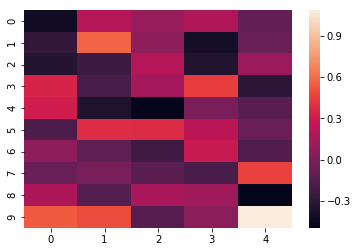

In [64]:
sns.heatmap(a)

In [60]:
a

array([[-0.42434576,  0.20934871,  0.10357593,  0.18740891, -0.09341835],
       [-0.2813046 ,  0.57178754,  0.07063107, -0.41012946, -0.07447869],
       [-0.34057674, -0.23615162,  0.20412059, -0.3479493 ,  0.11456454],
       [ 0.3472146 , -0.18560722,  0.15131548,  0.44755664, -0.3118925 ],
       [ 0.31629306, -0.37015098, -0.47746316, -0.01220629, -0.1252745 ],
       [-0.17676215,  0.3871225 ,  0.37786582,  0.22950386, -0.06629619],
       [ 0.0711855 , -0.10986173, -0.2337737 ,  0.28714225, -0.16402729],
       [-0.06859224, -0.0142671 , -0.11981684, -0.18700442,  0.46309483],
       [ 0.18234058, -0.14495003,  0.16160446,  0.1255119 , -0.4935804 ],
       [ 0.5378479 ,  0.4942607 , -0.14082202,  0.05298854,  1.0833267 ]],
      dtype=float32)

---------------------

In [10]:
df = pd.DataFrame({0: errs_list})
df.to_csv(HOME_DIR+'RPROP/'+'err_lists.csv', index=False)

df = pd.DataFrame({0: wts})
df.to_csv(HOME_DIR+'RPROP/'+'wts_lists.csv', index=False)

df = pd.DataFrame({0: lrs})
df.to_csv(HOME_DIR+'RPROP/'+'lrs_lists.csv', index=False)

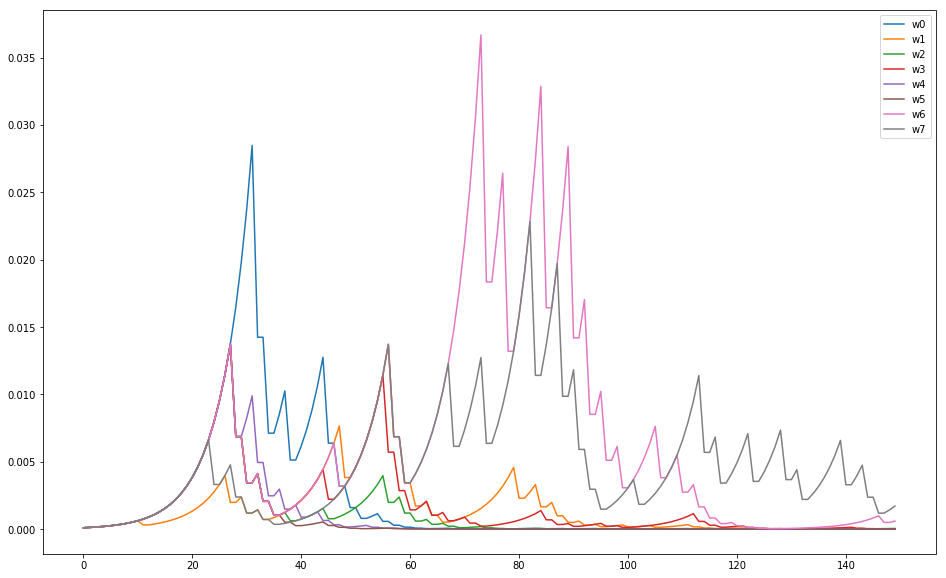

In [11]:
fig = plt.figure(figsize=(16, 10), clear=True)
idx=0
    
for j in range(len(wts)):
    plt.plot(wts[j], label = 'w'+str(idx))
    idx+=1

plt.legend()
    #plt.show()
plt.savefig(HOME_DIR+'RPROP/wts.png', bbox_inches='tight')

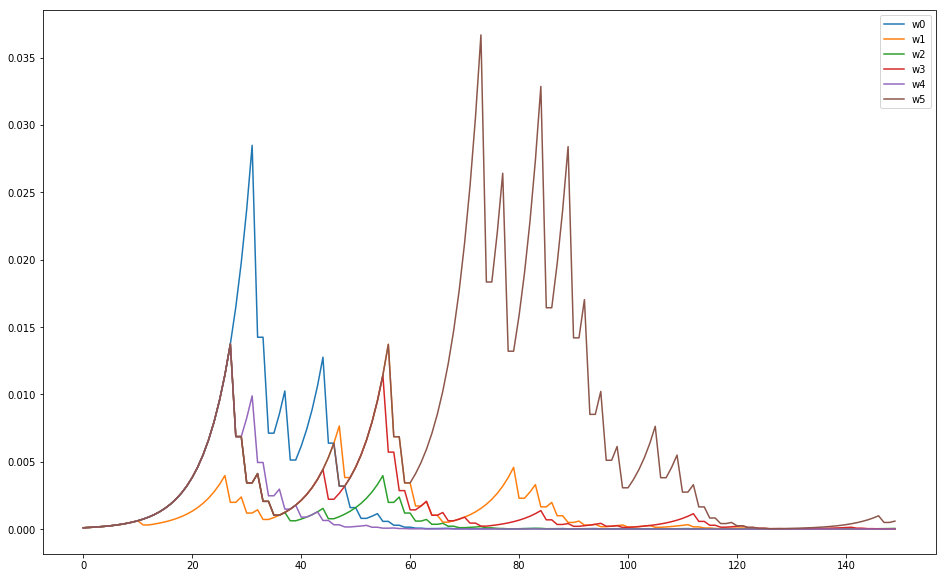

In [13]:
idx_list = [0, 1, 2, 3, 4, 6]

fig = plt.figure(figsize=(16, 10), clear=True)
idx=0
    
for j in idx_list:
    plt.plot(wts[j], label = 'w'+str(idx))
    idx+=1

plt.legend()
    #plt.show()
plt.savefig(HOME_DIR+'RPROP/wts_1.png', bbox_inches='tight')

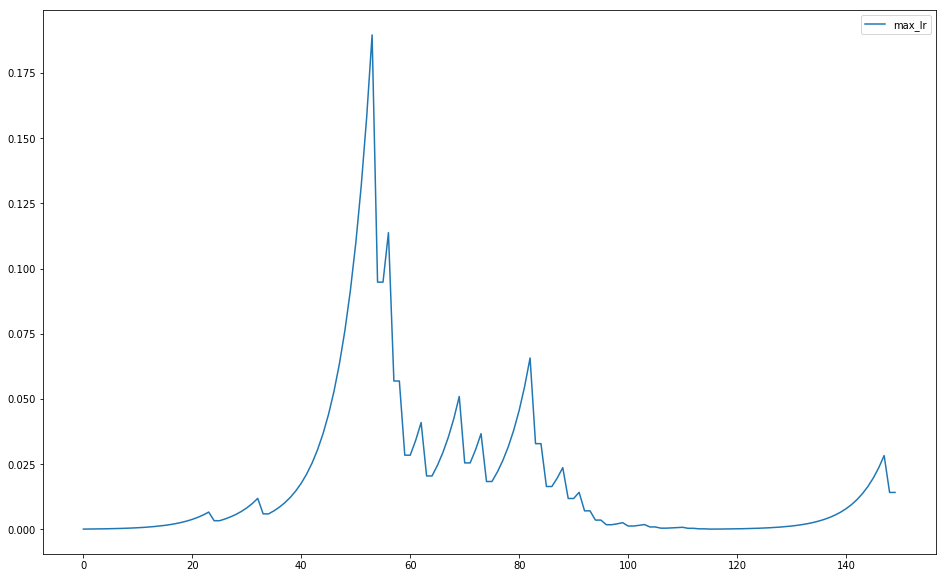

In [14]:
fig = plt.figure(figsize=(16, 10), clear=True)
    
for j in ['max']:
    plt.plot(lrs[j], label = j+'_lr')

plt.legend()
  #plt.show()
plt.savefig(HOME_DIR+'RPROP/lrs.png', bbox_inches='tight')

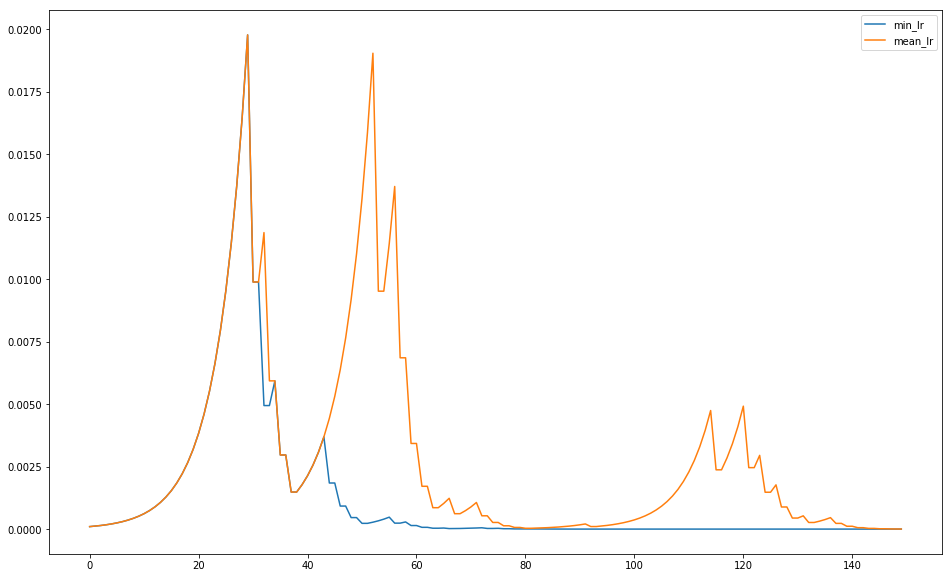

In [15]:
fig = plt.figure(figsize=(16, 10), clear=True)
    
for j in ['min', 'mean']:
    plt.plot(lrs[j], label = j+'_lr')

plt.legend()
  #plt.show()
plt.savefig(HOME_DIR+'RPROP/lrs_1.png', bbox_inches='tight')